In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
import pickle
from skimage import io
from extract_features import extract_features

In [54]:
# Where is the raw provided data
file_data_good = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Good.csv"
file_data_mixed = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Mixed.csv"
file_data_bad = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Bad.csv"

image_folders = [
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingGood",
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingMixed",
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingBad"
]

# Where we will store the features
file_features_good = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Good_features.csv"
file_features_mixed = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Mixed_features.csv"
file_features_bad = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Bad_features.csv"

def process_images(file_data, image_folder, file_features):
    # Read meta-data into a Pandas dataframe
    df = pd.read_csv(file_data)

    # Extract features from the image folder
    features_df = extract_features_folder(image_folder)

    # Merge the features DataFrame with the diagnostic column from the original DataFrame
    df_merged = pd.merge(df[['img_id', 'diagnostic']], features_df, on='img_id', how='inner')
    
    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_features)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    df_merged.to_csv(file_features, index=False)
    print(f"Processed Images in {image_folder}: Done")

def extract_features_folder(path_image):
    features = []

    for filename in os.listdir(path_image):
        if filename.endswith(('.jpg', '.png')):
            img_id = os.path.splitext(filename)[0]  # Remove file extension
            image_path = os.path.join(path_image, filename)
            image = io.imread(image_path)

            image_features = extract_features(image)
            image_features["img_id"] = img_id
            features.append(image_features)

    features_df = pd.DataFrame(features)
    return features_df

# Process images for each set
process_images(file_data_good, image_folders[0], file_features_good)
process_images(file_data_mixed, image_folders[1], file_features_mixed)
process_images(file_data_bad, image_folders[2], file_features_bad)

Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingGood: Done
Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingMixed: Done
Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingBad: Done


In [103]:
def get_metrics(classifiers, x, y, patient_id):
    num_folds = 5
    num_classifiers = len(classifiers)
    acc_val = np.empty([num_folds, num_classifiers])
    f1_val = np.empty([num_folds, num_classifiers])
    precision = np.empty([num_folds, num_classifiers])
    recall = np.empty([num_folds, num_classifiers])
    roc_auc = np.empty([num_folds, num_classifiers])
    for i, (train_index, val_index) in enumerate(group_kfold.split(x, y, patient_id)):
        x_train, x_val = x[train_index, :], x[val_index, :]
        y_train, y_val = y[train_index], y[val_index]
        for j, clf in enumerate(classifiers): 
            clf.fit(x_train, y_train)
            predictions = clf.predict(x_val)
            acc_val[i, j] = accuracy_score(y_val, predictions)
            f1_val[i, j] = f1_score(y_val, predictions)
            precision[i, j] = precision_score(y_val, predictions, zero_division=0)
            recall[i, j] = recall_score(y_val, predictions)
            roc_auc[i, j] = roc_auc_score(y_val, predictions)
    return acc_val, f1_val, precision, recall, roc_auc

# Define relative path for the features
relative_paths = [r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Good_features.csv", r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\mixed_features.csv", r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\bad_features.csv"]
datasets = ['Good', 'Mixed', 'Bad']

# Define classifiers
classifiers = [KNN(5), LR(max_iter=5000), DTC()]
classifier_names = ["KNN", "LR", "DTC"]

# Initialize an empty dataframe to store all the results
all_results = pd.DataFrame()

# Loop over datasets
for relative_path, dataset in zip(relative_paths, datasets):
    print(f"Processing {dataset} dataset...")
    # Read data
    df_merged = pd.read_csv(relative_path)
    x = np.array(df_merged.drop(['img_id', 'diagnostic'], axis=1))
    y = df_merged['diagnostic']
    patient_id = df_merged['img_id']
    group_kfold = GroupKFold(n_splits=5)

    # Define different feature selection methods
    feature_selections = {
        "None": x,
        "Variance Threshold": VarianceThreshold(threshold=0.1).fit_transform(x),
        "PCA": PCA(n_components=5).fit_transform(x)
    }

    # Loop over feature selections
    for feature_selection_name, x_selected in feature_selections.items():
        acc_val, f1_val, precision, recall, roc_auc = get_metrics(classifiers, x_selected, y, patient_id)

        # Loop over classifiers
        for clf, clf_name in zip(classifiers, classifier_names):
            # Prepare the results for this classifier and feature selection method
            results = {
                "Dataset": dataset,
                "Feature Selection": feature_selection_name,
                "Classifier": clf_name,
                "F1 Score": np.mean(f1_val),
                "Accuracy": np.mean(acc_val),
                "Precision": np.mean(precision),
                "Recall": np.mean(recall),
                "ROC AUC": np.mean(roc_auc)
            }
            # Append the results to the dataframe
            all_results = all_results.append(results, ignore_index=True)

            # Chosen classifier
            classifier = clf
            classifier = classifier.fit(x_selected, y)

            # Create a directory if it does not exist
            model_dir = fr"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/{dataset}/{feature_selection_name}"
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

            # Save the classifier
            model_path = f"{model_dir}/{clf_name}_model.pkl"
            pickle.dump(classifier, open(model_path, 'wb'))
            print(f"Saved {clf_name} model for {dataset} dataset with {feature_selection_name} feature selection at {model_path}.")


Processing Good dataset...
Saved KNN model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/KNN_model.pkl.
Saved LR model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/LR_model.pkl.
Saved DTC model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/DTC_model.pkl.
Saved KNN model for Good dataset with Variance Threshold feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/Variance Threshold/KNN_model.pkl.
Saved LR model for Good dataset with Variance Threshold feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/Variance Threshold/LR_model.pkl.
Saved DTC model for Good dataset with Variance Threshold feature select

In [58]:
all_results 

,Dataset,Feature Selection,Classifier,F1 Score,Accuracy,Precision,Recall,ROC AUC
0,Good,None,KNN,0.817866,0.746032,0.802589,0.854720,0.706581
1,Good,None,LR,0.817866,0.746032,0.802589,0.854720,0.706581
2,Good,None,DTC,0.817866,0.746032,0.802589,0.854720,0.706581
3,Good,Variance Threshold,KNN,0.805114,0.730159,0.795724,0.838543,0.691826
4,Good,Variance Threshold,LR,0.805114,0.730159,0.795724,0.838543,0.691826
5,Good,Variance Threshold,DTC,0.805114,0.730159,0.795724,0.838543,0.691826
6,Good,PCA,KNN,0.828681,0.761905,0.817374,0.862073,0.726448
7,Good,PCA,LR,0.828681,0.761905,0.817374,0.862073,0.726448
8,Good,PCA,DTC,0.828681,0.761905,0.817374,0.862073,0.726448
9,Mixed,None,KNN,0.692680,0.606349,0.659946,0.740904,0.560730


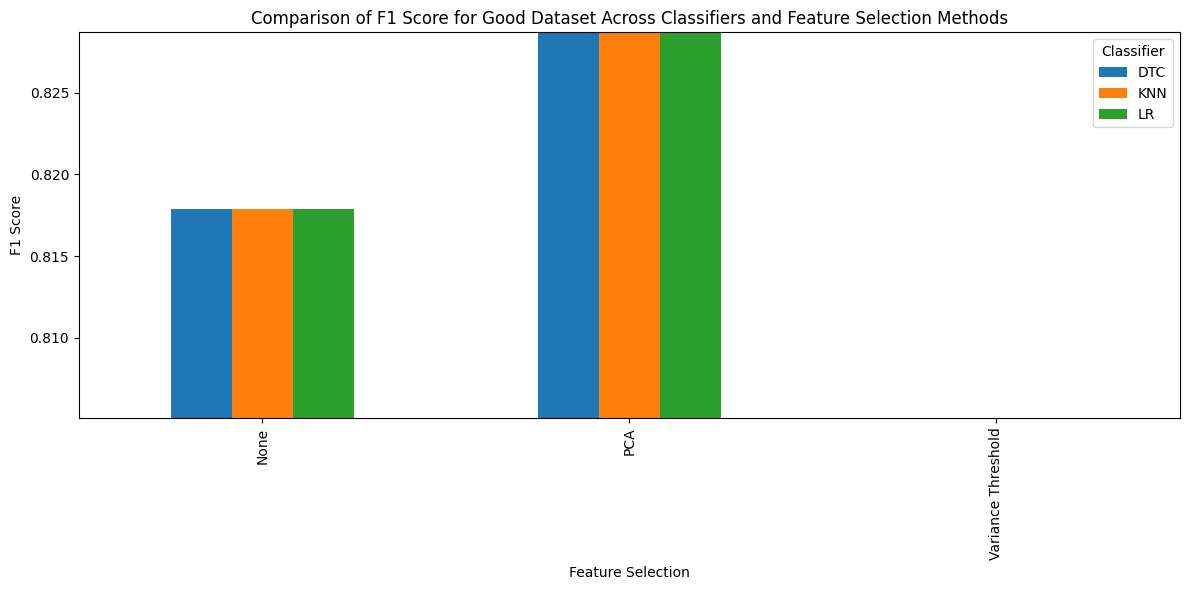

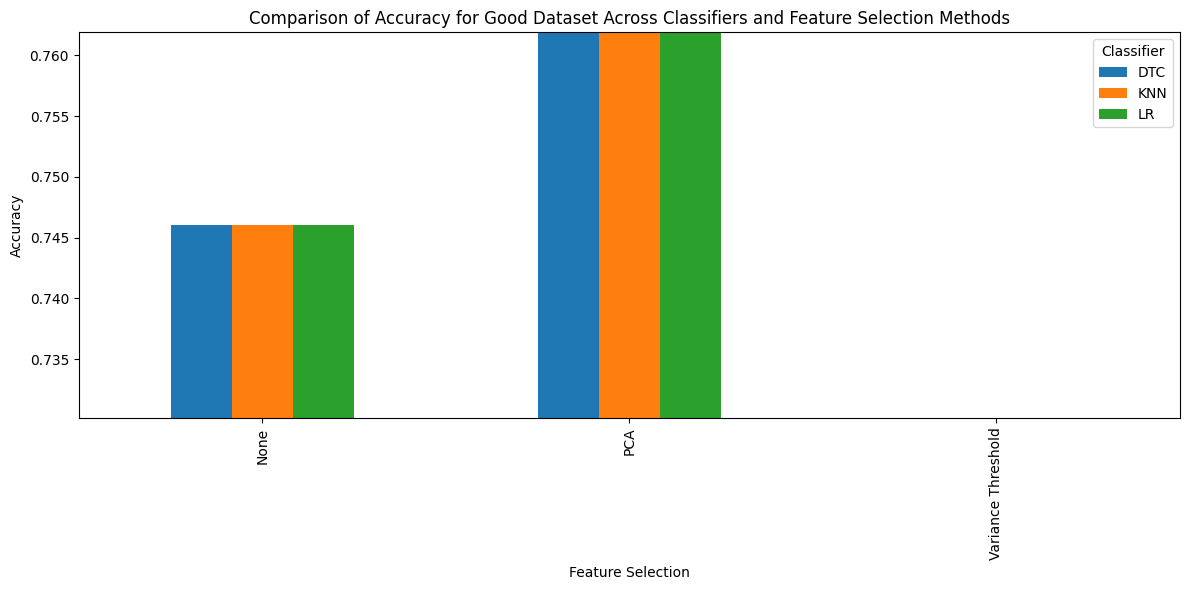

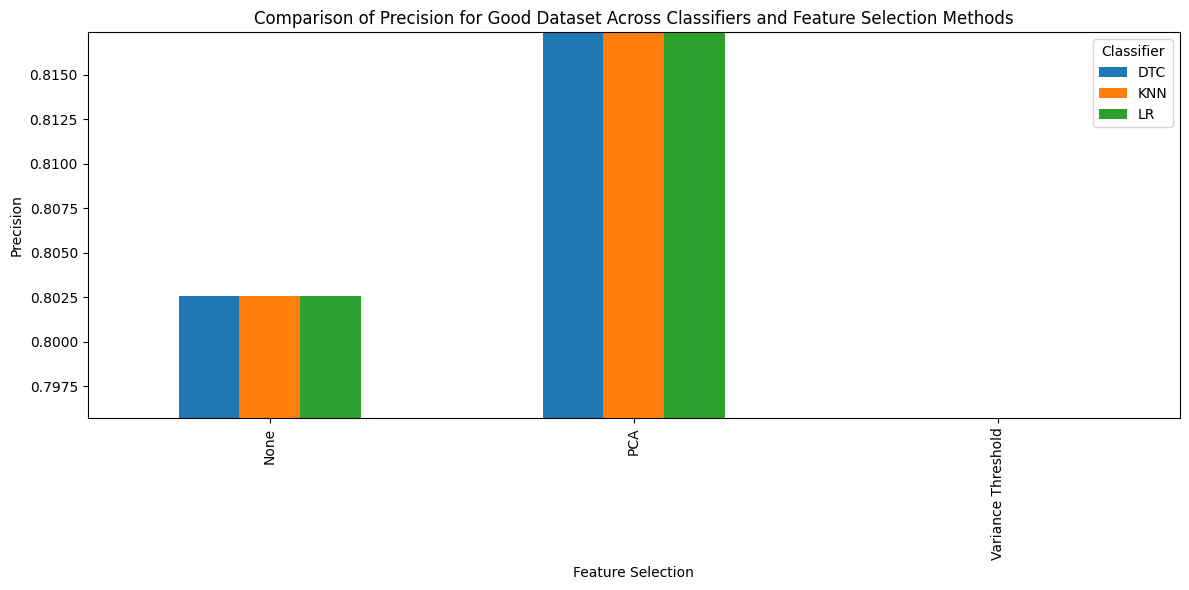

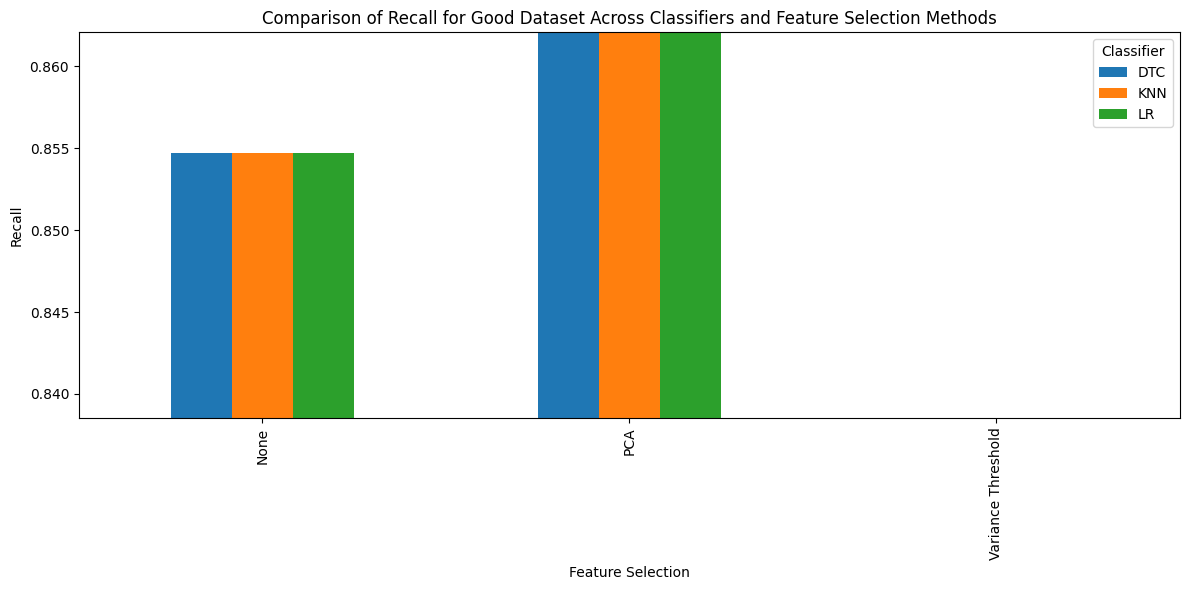

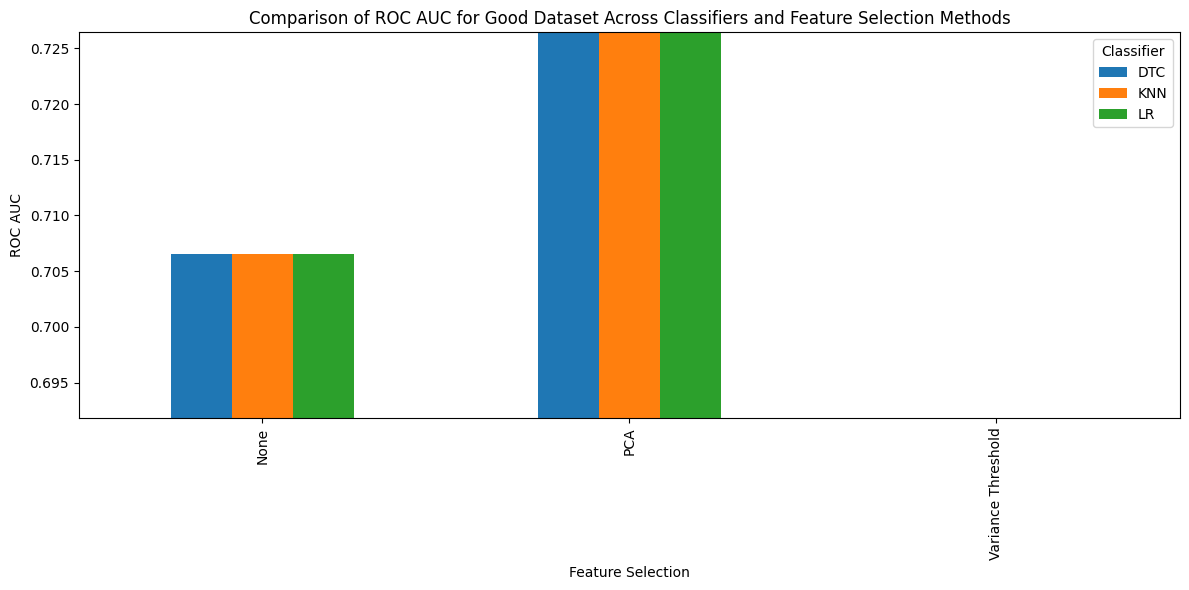

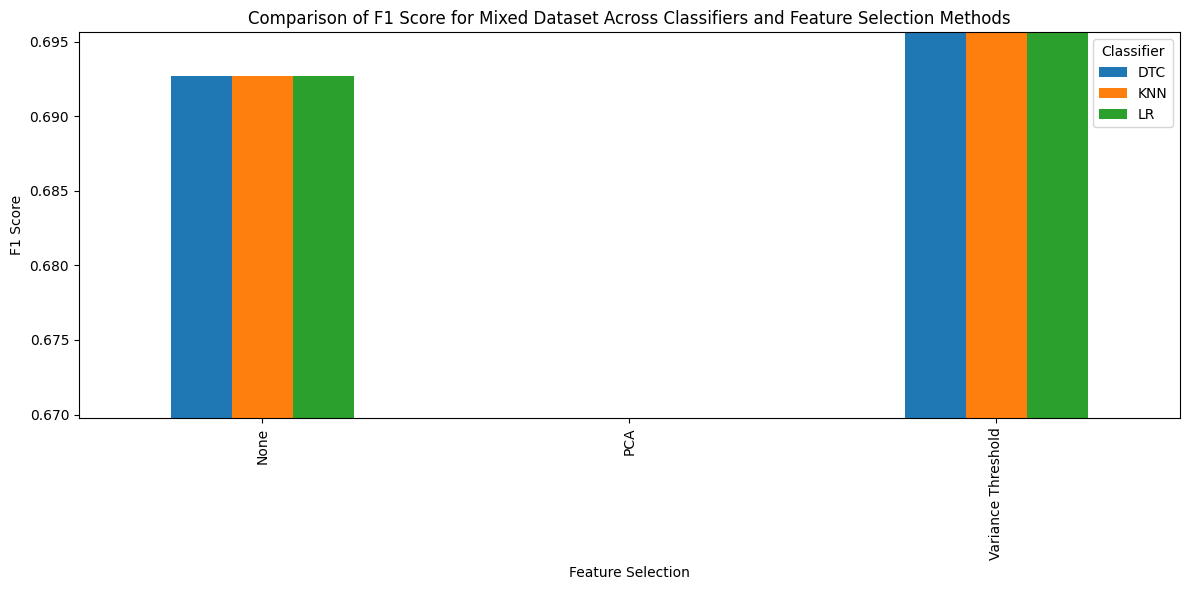

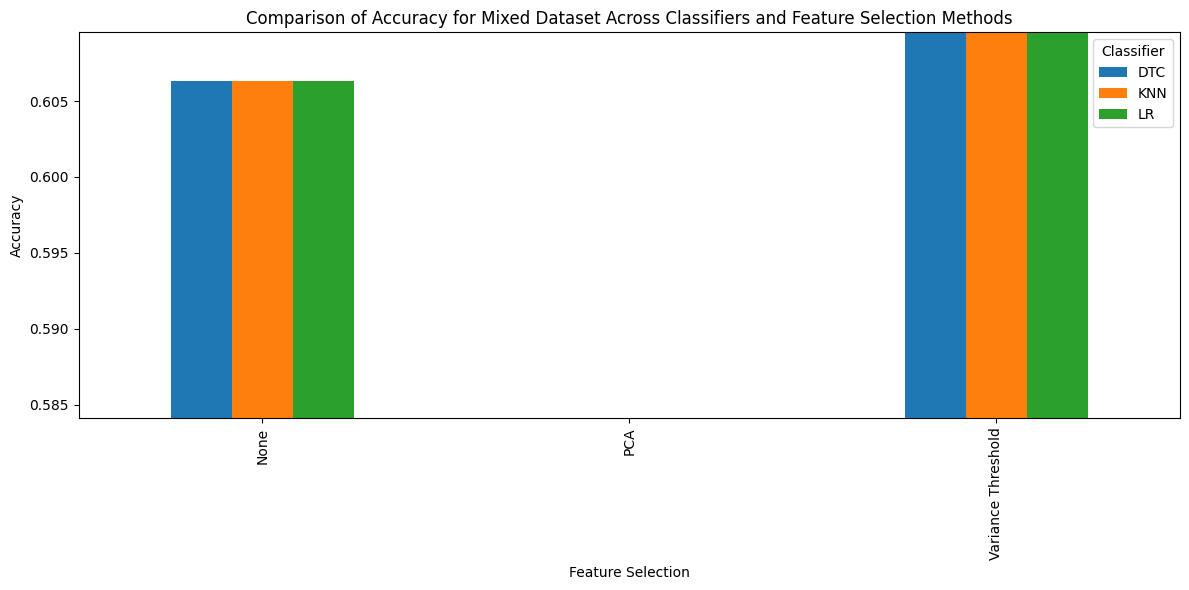

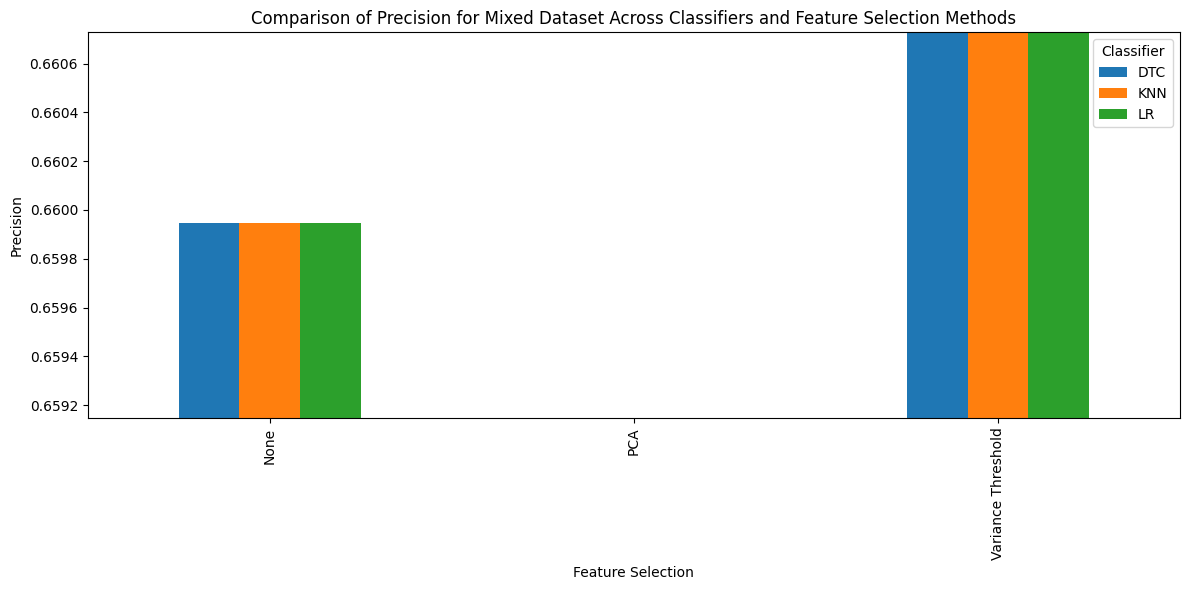

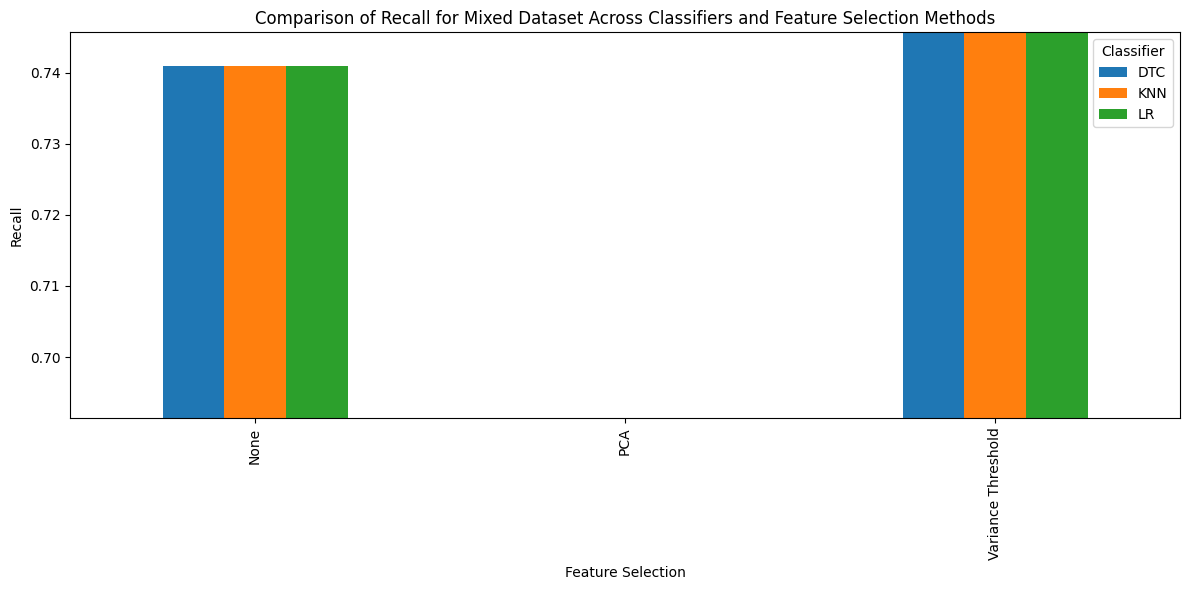

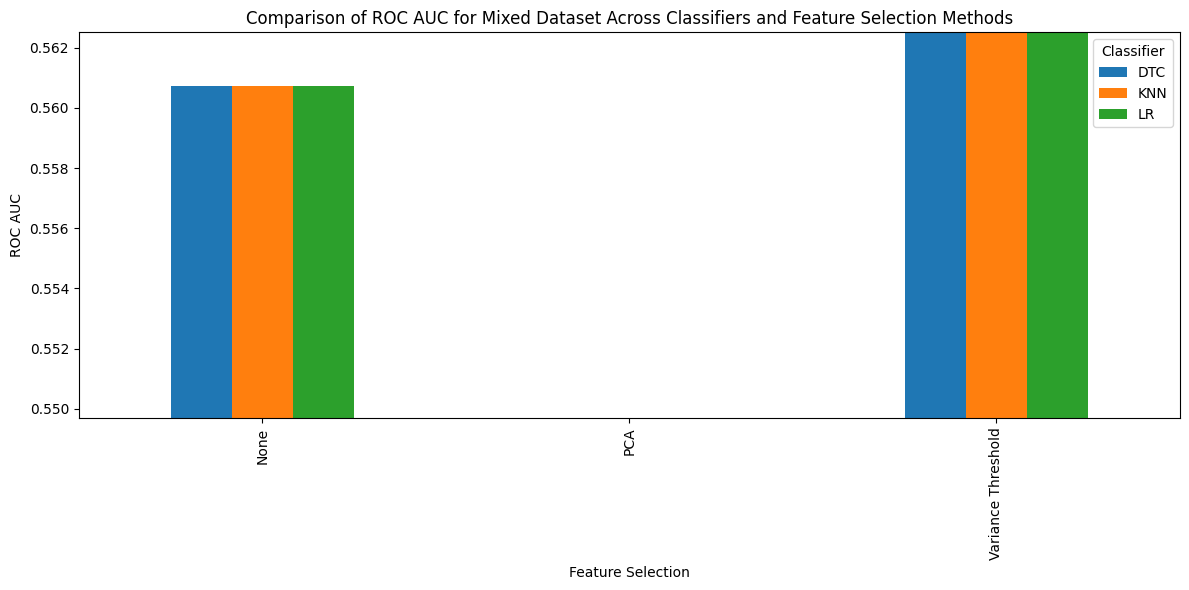

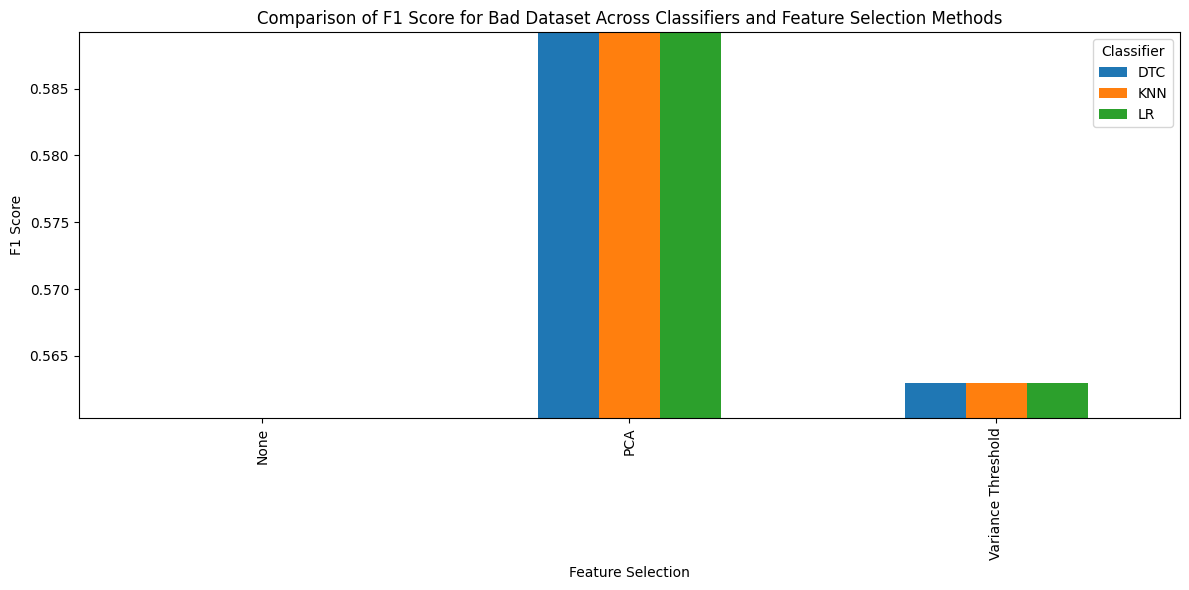

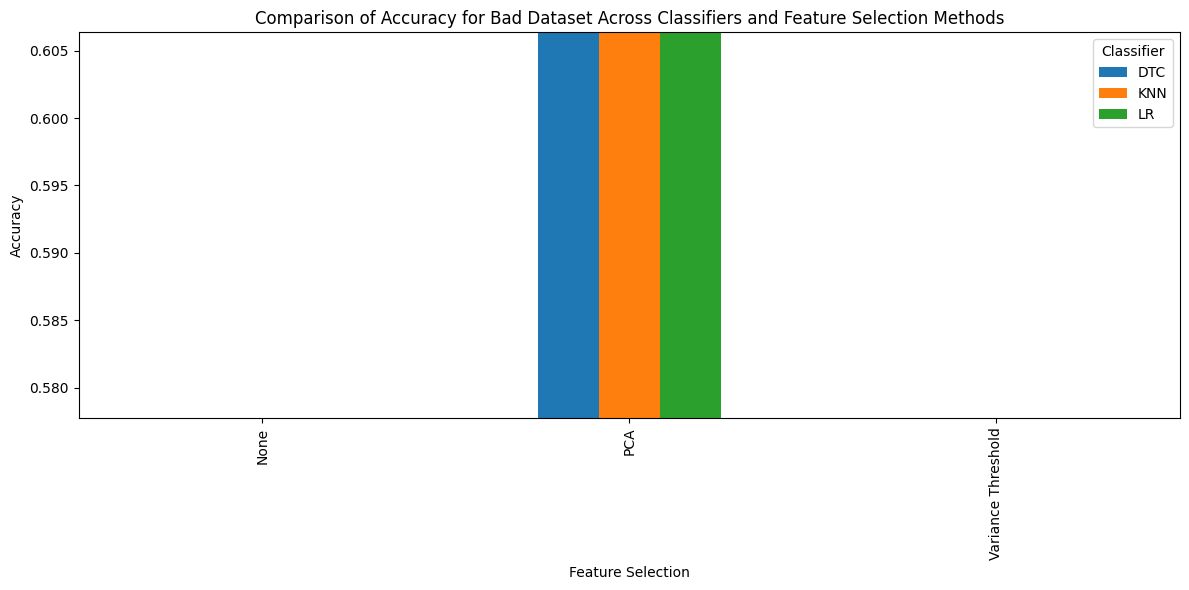

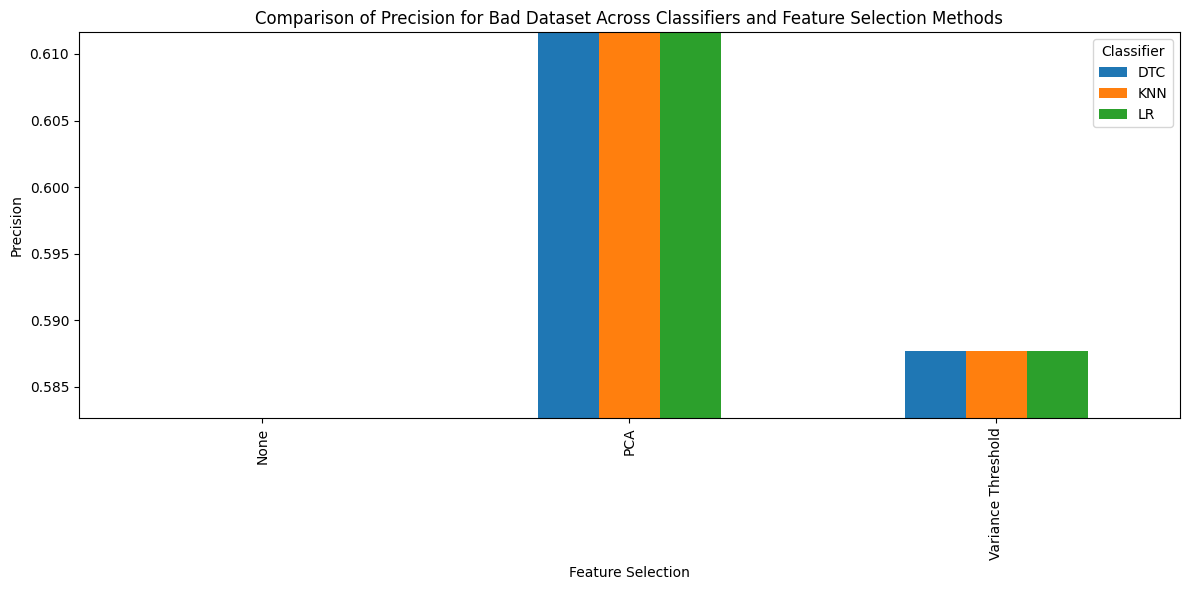

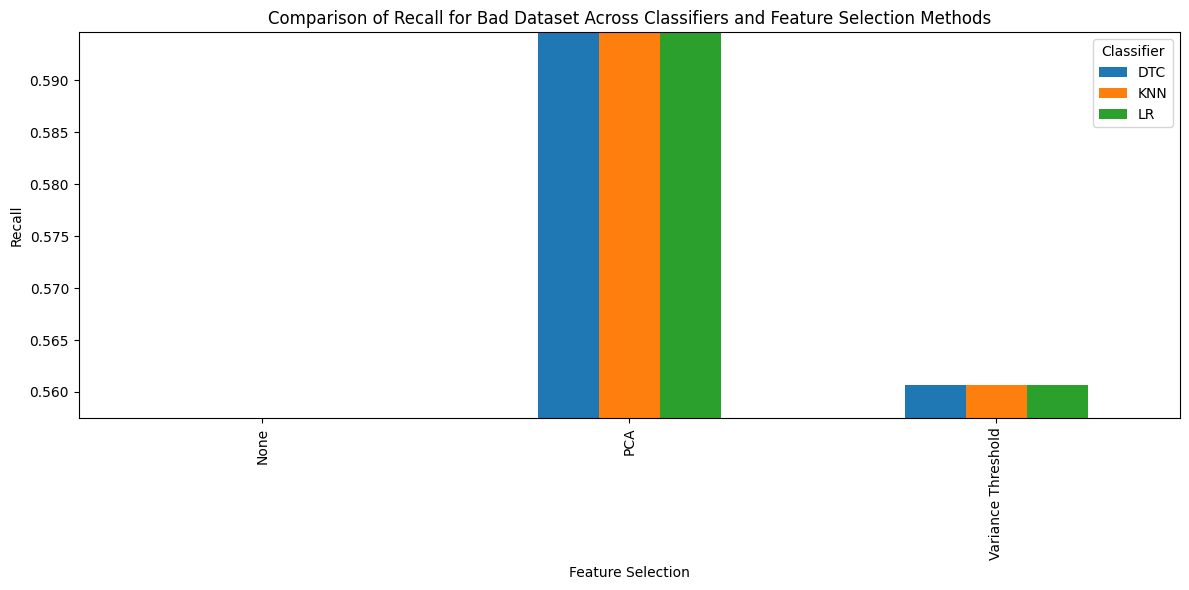

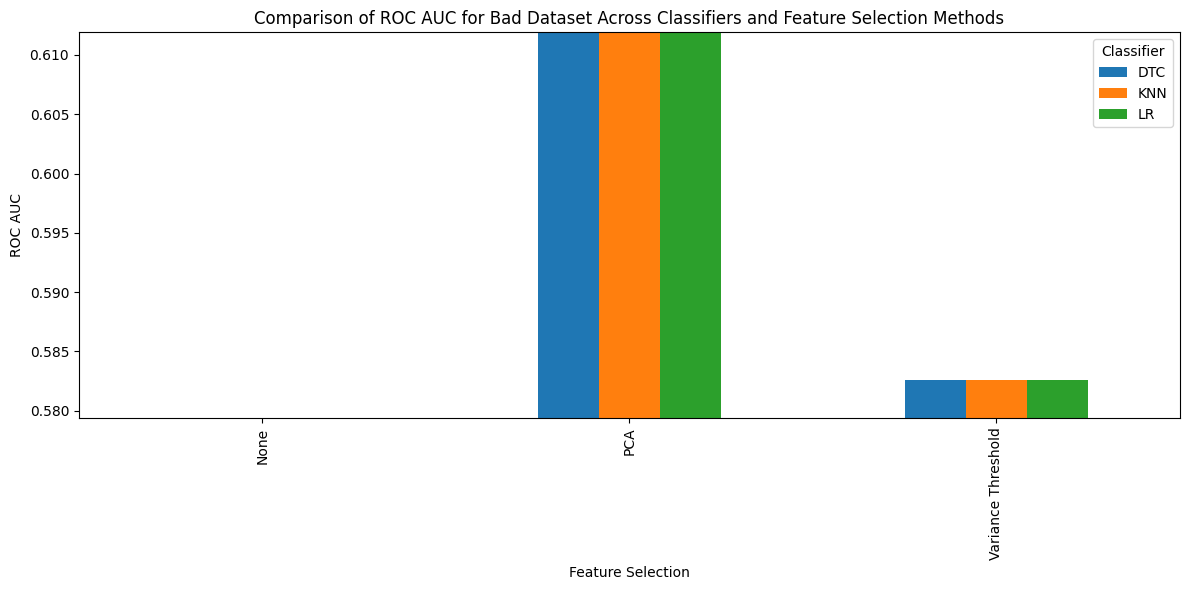

Best configuration for F1 Score:
Dataset                  Good
Feature Selection         PCA
Classifier                KNN
F1 Score             0.828681
Accuracy             0.761905
Precision            0.817374
Recall               0.862073
ROC AUC              0.726448
Name: 6, dtype: object
Best configuration for Accuracy:
Dataset                  Good
Feature Selection         PCA
Classifier                KNN
F1 Score             0.828681
Accuracy             0.761905
Precision            0.817374
Recall               0.862073
ROC AUC              0.726448
Name: 6, dtype: object
Best configuration for Precision:
Dataset                  Good
Feature Selection         PCA
Classifier                KNN
F1 Score             0.828681
Accuracy             0.761905
Precision            0.817374
Recall               0.862073
ROC AUC              0.726448
Name: 6, dtype: object
Best configuration for Recall:
Dataset                  Good
Feature Selection         PCA
Classifier          

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

datasets = all_results['Dataset'].unique()
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall', 'ROC AUC']

for dataset in datasets:
    for metric in metrics:
        subset = all_results[all_results['Dataset'] == dataset]
        pivot_table = subset.pivot_table(index='Feature Selection', columns='Classifier', values=metric)
        pivot_table.plot(kind='bar', figsize=(12,6))
        plt.title(f'Comparison of {metric} for {dataset} Dataset Across Classifiers and Feature Selection Methods')
        plt.ylabel(metric)
        plt.ylim([pivot_table.min().min(), pivot_table.max().max()]) # set y limits to min and max of each metric
        plt.tight_layout()
        plt.show()

# You can also find the best configuration for each metric
for metric in metrics:
    best_config = all_results.loc[all_results[metric].idxmax()]
    print(f'Best configuration for {metric}:')
    print(best_config)
